# Introduction

This tutorial explores the reconstruction of disease progression using deep learning, following example in the [[1]](https://www.nature.com/articles/s41467-017-00623-3). 

The dataset we use here is the **Diabetic Retinopathy Detection** dataset from the kaggle competition [[2]](https://www.kaggle.com/competitions/diabetic-retinopathy-detection/overview) - the same one that was used in the [[1]](https://www.nature.com/articles/s41467-017-00623-3). 

This dataset consists of retina images, each assosicated with the scale of diabetic retinopathy progression:

- 0 - Healthy
- 1 - Mild DR
- 2 - Moderate DR
- 3 - Severe DR
- 4 - Proliferative DR

In this tutorial, we use Convolutional Neural Network (namely - ResNet18) to classify this scale based on the retina images. Once the model is trained, we will use the output of pre-last layer to visualize the aligment of samples in the activation space. 


1. https://www.nature.com/articles/s41467-017-00623-3
2. https://www.kaggle.com/competitions/diabetic-retinopathy-detection/overview

## Setup environment


This tutorial requires several packages  that has to be installed separately as they are not in the dependencies of ehrapy: pytorch_lightning, sklearn,
timm,
torchsummary,
cellrank,
scvelo,

```
conda create -n ehrapylat python=3.9
```

## Download the data

1. To download tha data from kaggle competition, run in the command line the following command

```
kaggle competitions download -c diabetic-retinopathy-detection
```

2. Now, unzip the files by running the following commands in the terminal: 

```
cat train.zip.* >train.zip
unzip train.zip -d project_folder/raw_data 
```


We will organize our project folder in the following manner: 

```
.
└──ehrapy_tutorial_latents_extraction.ipynb 
└──project_folder 
    ├── raw_data           #we have extracted train.zip to this folder 
    |	├── images 
    |	├── labels 
    ├── processed_data 
    |	├──processed      #we will store cleaned df here 
    |	├──data_split     #we will store train/val/test split here 
    ├── experiments        #we will store model weights here 
    └── results            #we will store all results here: dataframes with predicted classes/latent representations, plots, etc 
```

## Now, let's set everything up - imports, constants, etc

### Imports

In [5]:
from pathlib import Path
import numpy as np
from enum import Enum
import ehrapy as ep
import pandas as pd
import os
import json

import pytorch_lightning as pl
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import WeightedRandomSampler
from torchvision import io
from typing import Union
import glob

import torch.nn.functional as F
from torchmetrics.functional import f1_score, accuracy

import torchvision.models as tm
from torch import Tensor
from torch import nn
from torchvision import transforms
from timm.data import auto_augment

import shutil
from torchsummary import summary
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

from sklearn.metrics import classification_report
import pickle as pkl
from tqdm import tqdm
import random

In [2]:
ep.print_versions()

-----
ehrapy              0.3.0
rich                NA
session_info        1.0.0
-----
PIL                 7.2.0
anndata             0.9.1
anyio               NA
arrow               1.2.3
astor               0.8.1
asttokens           NA
attr                23.1.0
autograd            NA
autograd_gamma      NA
babel               2.12.1
backcall            0.2.0
backports           NA
bs4                 4.12.2
category_encoders   2.6.1
certifi             2023.05.07
cffi                1.15.1
charset_normalizer  3.1.0
colorama            0.4.6
comm                0.1.3
cvxopt              1.3.1
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
deep_translator     1.9.1
deepl               1.14.0
defusedxml          0.7.1
dill                0.3.6
executing           1.2.0
fastjsonschema      NA
filelock            3.12.0
formulaic           0.6.1
fqdn                NA
fsspec              2023.5.0
future              0.18.3
google              NA
graphlib            NA
h5py                3.8.0
html5lib            1.1
huggingface_hub     0.15.1
idna                3.4
igraph              0.10.4
importlib_resources NA
interface_meta      1.3.0
ipykernel           6.23.1
ipython_genutils    0.2.0
ipywidgets          8.0.6
isoduration         NA
jedi                0.18.2
jinja2              3.1.2
joblib              1.2.0
json5               NA
jsonpointer         2.3
jsonschema          4.17.3
jupyter_events      0.6.3
jupyter_server      2.6.0
jupyterlab_server   2.22.1
kiwisolver          1.4.4
leidenalg           0.9.1
lifelines           0.27.7
lightning_fabric    2.0.2
lightning_utilities 0.8.0
llvmlite            0.40.0
markupsafe          2.1.2
matplotlib          3.7.1
missingno           0.5.2
mpl_toolkits        NA
mudata              0.2.2
natsort             8.3.1
nbformat            5.9.0
numba               0.57.0
numpy               1.24.3
opt_einsum          v3.3.0
overrides           NA
packaging           23.1
pandas              2.0.2
parso               0.8.3
patsy               0.5.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
platformdirs        3.5.1
plotly              5.14.1
prometheus_client   NA
prompt_toolkit      3.0.38
psutil              5.9.5
ptyprocess          0.7.0
pure_eval           0.2.2
pvectorc            NA
pydantic            1.10.8
pydev_ipython       NA
pydevconsole        NA
pydevd              2.9.5
pydevd_file_utils   NA
pydevd_plugins      NA
pydevd_tracing      NA
pygments            2.15.1
pyhpo               3.1.5
pyparsing           3.0.9
pypi_latest         0.1.2
pyrsistent          NA
pythonjsonlogger    NA
pytorch_lightning   2.0.2
pytz                2023.3
questionary         1.10.0
regex               2.5.129
requests            2.31.0
rfc3339_validator   0.1.4
rfc3986_validator   0.1.1
safetensors         0.3.1
scanpy              1.9.3
scipy               1.10.1
seaborn             0.12.2
send2trash          NA
setuptools          67.8.0
six                 1.16.0
sklearn             1.1.3
sniffio             1.3.0
socks               1.7.1
soupsieve           2.4.1
stack_data          0.6.2
statsmodels         0.14.0
texttable           1.6.7
threadpoolctl       3.1.0
timm                0.9.2
tokenizers          0.12.1
torch               1.13.1
torchmetrics        0.11.4
torchsummary        NA
torchvision         0.14.1
tornado             6.3.2
tqdm                4.65.0
traitlets           5.9.0
typing_extensions   NA
uri_template        NA
urllib3             1.26.16
wcwidth             0.2.6
webcolors           1.13
webencodings        0.5.1
websocket           1.5.2
wrapt               1.15.0
yaml                6.0
zipp                NA
zmq                 25.1.0
zoneinfo            NA
-----
IPython             8.13.2
jupyter_client      8.2.0
jupyter_core        5.3.0
jupyterlab          3.6.4
notebook            6.5.4
-----
Python 3.9.16 (main, Mar  8

### Constant paths and label encoding

In [6]:
ROOT = Path(os.getcwd())
PROJECT_DIR = ROOT / "project_folder"
RAWDATA_DIR = PROJECT_DIR / "raw_data"

MODELS_DIR = PROJECT_DIR / "experiments"
RESULTS_DIR = PROJECT_DIR / "results"
PROCESSED_DIR = PROJECT_DIR / "processed_data" / "processed"
DATASPLIT_DIR = PROJECT_DIR / "processed_data" / "data_split"


label_map = {0: "Normal", 1: "Mild", 2: "Medium", 3: "Severe", 4: "Proliferative"}

## Diabetic Retinopathy preprocessing

First, let's read and display annotation file and get patient id and laterality as separate columns

In [37]:
annotations_file = RAWDATA_DIR / "labels" / "trainLabels.csv"
labels = pd.read_csv(annotations_file)

labels["patient_id"] = labels.apply(lambda x: x.image.split("_")[0], axis=1)
labels["laterality"] = labels.apply(
    lambda x: str.upper(x.image.split("_")[1][0]), axis=1
)

labels["level_decoded"] = labels[["level"]].replace({"level": label_map})

labels.head()

,image,level,patient_id,laterality,level_decoded
0,10_left,0,10,L,Normal
1,10_right,0,10,R,Normal
2,13_left,0,13,L,Normal
3,13_right,0,13,R,Normal
4,15_left,1,15,L,Mild


Lets see how many patients had different diagnosis for different eyes

### Save only patients who had the same diagnosis both eyes

In [40]:
# Info on patients with 2 eyes:
def mark_groups(group):
    different_diagnosis = group["level"].nunique() > 1
    group["different_diagnosis"] = different_diagnosis

    return group


labels = labels.groupby("patient_id", as_index=False).apply(lambda x: mark_groups(x))
# keep=False =>  Mark all duplicates as True
labels.reset_index(inplace=True, drop=True)

In [41]:
os.makedirs(PROCESSED_DIR, exist_ok=True)
labels[~labels.different_diagnosis].to_csv(
    PROCESSED_DIR / "labels_wo_diff_diagnosis.csv", index=False
)

### Data split  = train 0.6 / val 0.1 test 0.3

In [27]:
from sklearn.model_selection import train_test_split


def create_random_split(
    df,
    n_train=0.6,
    n_val=0.1,
    random_state=228,
    stratificaion_col="level",
):
    """
    Split data at the subject level into training, (optional) validation and test set with equivalent response_col and additional stratification columns distributions at the first visit
    Pipeline:
        1. Drop duplicated "patient_id" entries, so we are left with one row per patient_id.
         Note: we assume filtering was done before, so that if patient had 2 eyes recorded, both had same response type, or otherwise the patient was filtered out.
        2. Collapse all columns that should be used for stratification into one joint column
        3. split df into train_val and test dataset using joint stratification as a stratification factor
        4. if n_val > 0, we will split train_val dataset into train and validation subsets, otherwise we will assign train_val as train and leave val empty

    :param df: dataframe to split, assumes df to not contain duplicates
    :param n_train: ratio of patient ids which will end up in train set. Test set size is the (1-n_train-n_val)
    :param n_val: ratio of patient ids which will end up in val set. Test set size is the (1-n_train-n_val)
    :param random_state:
    :param stratificaion_col: main column by which to stratify. Response type by default
    :return:
    """
    assert n_train + n_val < 1

    return_columns = ["patient_id", stratificaion_col]
    full_df = df.copy()

    train_val_df, test_df = train_test_split(
        full_df,
        train_size=n_train + n_val,
        random_state=random_state,
        stratify=full_df[stratificaion_col].values,
    )

    if n_val > 0:
        train_df, val_df = train_test_split(
            train_val_df,
            train_size=n_train / (n_train + n_val),
            random_state=random_state,
            stratify=train_val_df[stratificaion_col].values,
        )
    else:
        train_df = train_val_df
        val_df = pd.DataFrame(columns=train_df.columns)

    assert [
        (el not in list(test_df.patient_id.values))
        for el in list(train_df.patient_id.values)
    ]

    assert [
        (el not in list(test_df.patient_id.values))
        for el in list(val_df.patient_id.values)
    ]

    assert [
        (el not in list(train_df.patient_id.values))
        for el in list(val_df.patient_id.values)
    ]
    return {
        "train": train_df[return_columns],
        "val": val_df[return_columns],
        "test": test_df[return_columns],
    }


def split_sequences(
    input_path,
    result_folder,
    n_train=0.6,
    n_val=0.1,
    random_state=228,
    response_col="level",
    subset="wo_diff_diagnosis",
):
    """
    Takes data from "responders_filepath" and splits by "patient_id, laterality

    :param df_path:
    :param result_folder:
    :param n_train:
    :param random_state:
    :param response_col:
    :return:
    """
    raw_df = pd.read_csv(str(input_path / f"labels_{subset}.csv"))

    print(
        "Data distribution of the full dataset \n",
        raw_df[response_col].value_counts(normalize=True),
    )

    df_wo_dups = raw_df.drop_duplicates(["patient_id"], keep="first")

    df_wo_dups.reset_index(inplace=True, drop=True)
    print(
        "Data distribution of the dataset w/o duplicated patients  \n",
        df_wo_dups[response_col].value_counts(normalize=True),
    )

    split_dict = create_random_split(
        df_wo_dups,
        n_train=n_train,
        n_val=n_val,
        random_state=random_state,
        stratificaion_col=response_col,
    )

    os.makedirs(result_folder, exist_ok=True)
    for key in split_dict.keys():
        df = split_dict[key]
        df_merged = pd.merge(raw_df, df[["patient_id"]], on="patient_id", how="inner")

        print(
            f"Data distribution of the {key} dataset of len {df_merged.shape[0]}, ratio is {df_merged.shape[0]/raw_df.shape[0]}\n",
            df_merged[response_col].value_counts(),
        )

        df_merged.to_csv(os.path.join(result_folder, f"{key}_df.csv"), index=False)

In [40]:
split_sequences(
    input_path=PROCESSED_DIR,
    result_folder=DATASPLIT_DIR,
    n_train=0.6,
    n_val=0.1,
)

Data distribution of the full dataset 
 level
0    0.793252
2    0.130392
1    0.039157
3    0.020035
4    0.017164
Name: proportion, dtype: float64
Data distribution of the dataset w/o duplicated patients  
 level
0    0.793252
2    0.130392
1    0.039157
3    0.020035
4    0.017164
Name: proportion, dtype: float64
Data distribution of the train dataset of len 18386, ratio is 0.5999477909025648
 level
0    14584
2     2398
1      720
3      368
4      316
Name: count, dtype: int64
Data distribution of the val dataset of len 3066, ratio is 0.10004568296025583
 level
0    2432
2     400
1     120
3      62
4      52
Name: count, dtype: int64
Data distribution of the test dataset of len 9194, ratio is 0.30000652613717943
 level
0    7294
2    1198
1     360
3     184
4     158
Name: count, dtype: int64


# Training prepararion

## Data-related wrappers

First, some additional enumerated classes - we'll need them to avoid typos

In [42]:
# constants for subset/pipline stages
class SplitSubset(Enum):
    train = "train"
    val = "val"
    test = "test"


class Stage(Enum):
    fit = "fit"
    test = "test"
    predict = "predict"


class PredictionType(Enum):
    latents = "latents"
    class_label = "class_label"

### Set up a custom dataset

Now, we need a Dataset class for reading providing us with input/label pairs

In [43]:
class RetinaDataset(Dataset):
    def __init__(
        self,
        input_transforms=None,
        target_transform=None,
        subset=SplitSubset.train,
    ):
        self.img_labels = pd.read_csv(str(DATASPLIT_DIR / f"{subset.value}_df.csv"))
        print(
            f"loaded labels from {str(DATASPLIT_DIR / f'{subset.value}_df.csv')}, shape: {self.img_labels.shape}"
        )
        self.img_dir = RAWDATA_DIR / "images"
        self.input_transforms = input_transforms
        self.target_transform = target_transform
        self.subset = subset

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        row = self.img_labels.iloc[idx]
        image = self.read_img(self.img_dir / f"{row.image}.jpeg")
        label = row.level
        if self.input_transforms is not None:
            image = self.input_transforms(image)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return {"image": image, "label": label, "record_name": f"{row.image}"}

    def read_img(self, filepath):
        image = io.read_image(str(filepath))
        if image.shape[-1] == 3:
            image = image.permute(0, 3, 1, 2)
        image = torch.div(image, 255.0)
        return image

In [53]:
retina_dataset = RetinaDataset(input_transforms=None, subset=SplitSubset.train)


loaded labels from /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/processed_data/data_split/train_df.csv, shape: (18386, 6)


12

In [54]:
retina_dataset.img_labels.level.unique()

array([0, 4, 1, 2, 3])

Let's create an object of this class to see an example of how its working

loaded labels from /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/processed_data/data_split/train_df.csv, shape: (18386, 6)
Loaded from: /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/raw_data/images/100_left.jpeg


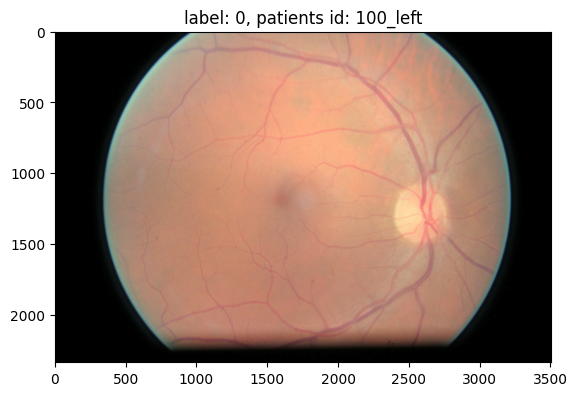

Loaded from: /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/raw_data/images/10030_left.jpeg


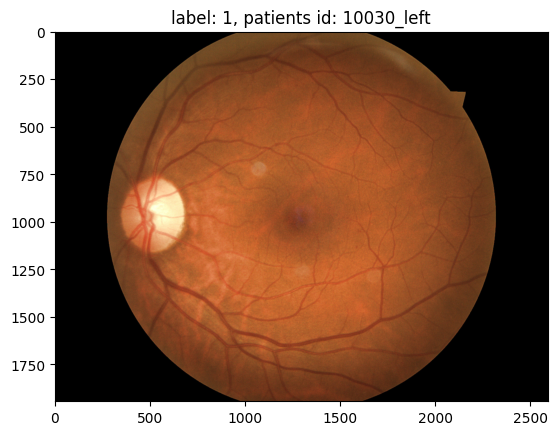

Loaded from: /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/raw_data/images/10120_left.jpeg


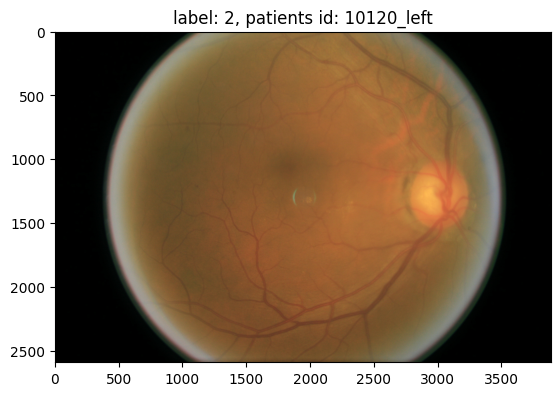

Loaded from: /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/raw_data/images/10153_left.jpeg


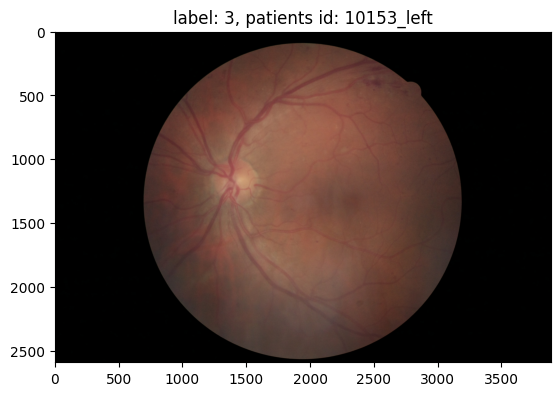

Loaded from: /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/raw_data/images/10017_left.jpeg


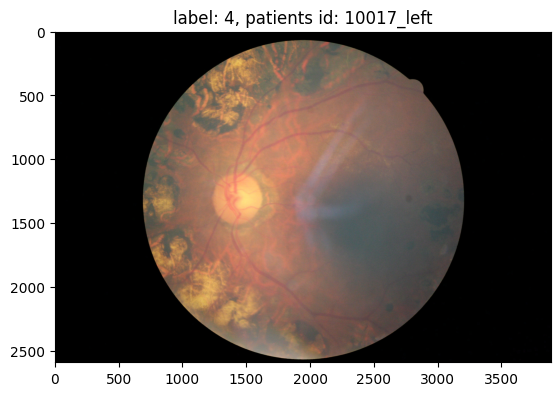

In [59]:
import matplotlib.pyplot as plt

retina_dataset = RetinaDataset(input_transforms=None, subset=SplitSubset.train)
for label in range(retina_dataset.img_labels.level.nunique()):
    idx= retina_dataset.img_labels[retina_dataset.img_labels.level==label].index.tolist()[0]
    row = retina_dataset.img_labels.iloc[idx]
    print("Loaded from:", retina_dataset.img_dir / f"{row.image}.jpeg")
    item_dict = retina_dataset.__getitem__(idx=idx)
    

    plt.imshow(item_dict["image"].permute(1, 2, 0))
    plt.title(f"label: {item_dict['label']}, patients id: {item_dict['record_name']}")
    plt.show()
    plt.close()

### Set up a custom torchlightning dataloader

Now, we will use **torchlightning** - a tool that helps to simplify deep learning model development and training. 

Folowing an example [here](https://lightning.ai/docs/pytorch/stable/data/datamodule.html#train-dataloader), we will create a a data module class that will be a wrapper around the dataset and will be used to manage it during the training/inference stages. 

In [16]:
class RetinaDatamoduleTL(pl.LightningDataModule):
    def __init__(
        self,
        batch_size: int = 32,
        num_workers: int = 12,
        seed=5,
        weighted_sampler=True,
        use_augmentations=True,
    ):
        super().__init__()

        self.batch_size = batch_size
        self.num_workers = num_workers

        self.seed = seed
        self.g = torch.Generator()
        self.g.manual_seed(self.seed)
        self.weighted_sampler = weighted_sampler
        self.use_augmentations = use_augmentations

    def setup(self, stage:Union[Stage, None]=None, subset:Union[SplitSubset, None]=None):
        """Prepare dataloader for the specific stage: fit (= model training), test or predict (= models inference)

        Args:
            stage (Union[Stage, None], optional): stage of the pipeline. For example, if set to "fit", that means the model will be in the fitting stage (training).. Defaults to None.
            subset (SplitSubset, None], optional): Only relevant when stage!= stage.fit. Subset of the dataset that should be used: train, validation or test. Defaults to None. Note that we left both stage and subset for the inference stage since we might wish to predict on train subset, and not only on test.
        """

        
        if stage == Stage.fit or stage is None:
            print(f"Setting up for stage: {stage}")
            
            #depending on the stage, different set of transformations are used - additional augmantations for train, no augmentations for val/test
    
            input_transforms_train = self.get_transforms(use_augmentations=self.use_augmentations, stage=stage)
            input_transforms_val = self.get_transforms(use_augmentations=False, stage=stage)
            

            self.dt_train = RetinaDataset(
                input_transforms=input_transforms_train, subset=SplitSubset.train
            )

            self.dt_val = RetinaDataset(
                input_transforms=input_transforms_val, subset=SplitSubset.val
            )

        if stage == Stage.test or stage == Stage.predict:
            print(f"Settin up for stage: {stage}, subset: {subset}")
            input_transforms_test = self.get_transforms(use_augmentations=False, stage=stage)
            
            self.dt_test = RetinaDataset(input_transforms=input_transforms_test, subset=subset)

    def train_dataloader(self):
        # here, we have an option to either have a random sampling or a weighted sampler which helps in case of imbalanced class distribution. 
        #hence we first create a sampler that will be used in the training dataloader. 
        train_sampler = self._get_train_sampler()
        
        return DataLoader(
            self.dt_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            sampler=train_sampler,
            generator=self.g,
        )
        

    def val_dataloader(self):
        return DataLoader(
            self.dt_val,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            generator=self.g,
        )

    def test_dataloader(self):
        return DataLoader(
            self.dt_test,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            generator=self.g,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.dt_test,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            generator=self.g,
        )
    
    def _get_train_sampler(self):
        if self.weighted_sampler:
            class_counts = self.dt_train.img_labels.level.value_counts()
            sample_weights = [
                1 / class_counts[i] for i in self.dt_train.img_labels.level.values
            ]
            train_sampler = WeightedRandomSampler(
                weights=sample_weights,
                num_samples=self.dt_train.img_labels.shape[0],
                replacement=True,
                generator=self.g,
            )
            return train_sampler

        else:
            return None

    def _get_general_transforms(self):
        transform = transforms.Compose(
            [
                transforms.Resize((256, 256)),
                transforms.CenterCrop(224),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        return transform

    def _get_transforms_with_augmentations(self):
        augmentations = auto_augment.rand_augment_transform(
            config_str="rand-m9-mstd0.5", hparams={}
        )
        train_transforms = transforms.Compose(
            [
                transforms.Resize((256, 256)),
                transforms.CenterCrop(224),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToPILImage(),
                augmentations,
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        return train_transforms

    def get_transforms(self, use_augmentations=True, stage: Stage = Stage.fit):
        """get a set of transformations for the dataset. 

        Args:
            use_augmentations (bool, optional): only relevant if stage == Stage.fit. Defaults to True.
            stage (Stage, optional): stage of the pipeline. If we're at the inference stage, no augmentation will be applied. Defaults to Stage.fit.

        Returns:
        
        """
        if use_augmentations and stage == Stage.fit:
            transforms = self._get_transforms_with_augmentations()
        else:
            transforms = self._get_general_transforms()
        return transforms

Lets get an example of datamodule and check how it works - we'll get train subset to also see an influence of augmentations

Setting up for stage: Stage.fit
loaded labels from /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/processed_data/data_split/train_df.csv, shape: (18386, 6)
loaded labels from /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/processed_data/data_split/val_df.csv, shape: (3066, 6)
Setting up for stage: Stage.fit
loaded labels from /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/processed_data/data_split/train_df.csv, shape: (18386, 6)
loaded labels from /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/processed_data/data_split/val_df.csv, shape: (3066, 6)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


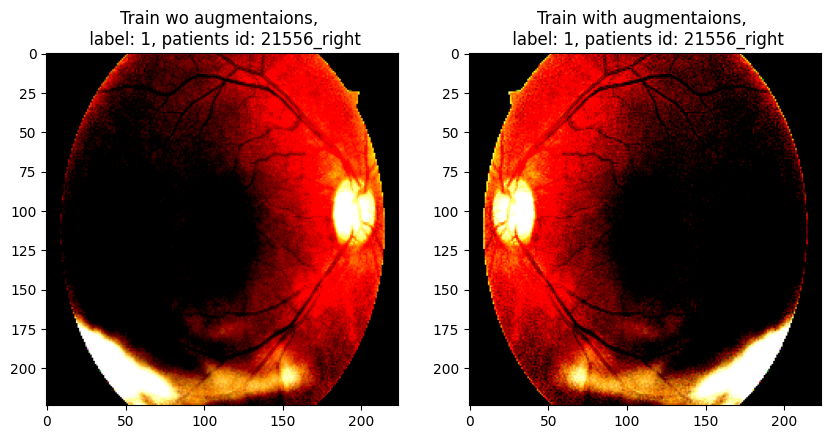

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


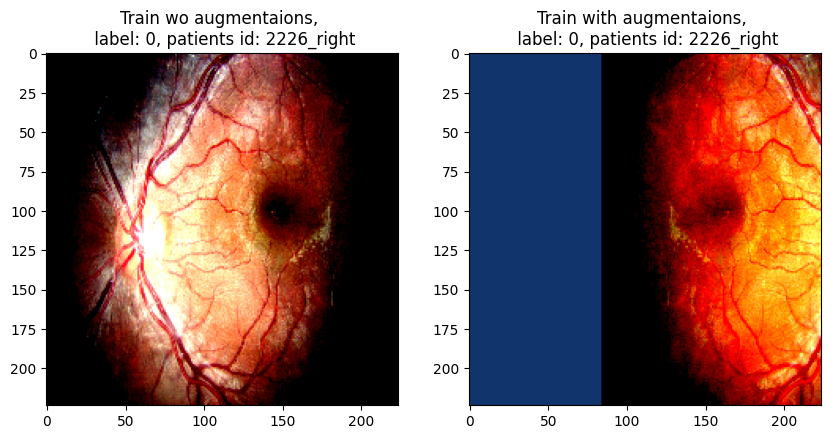

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


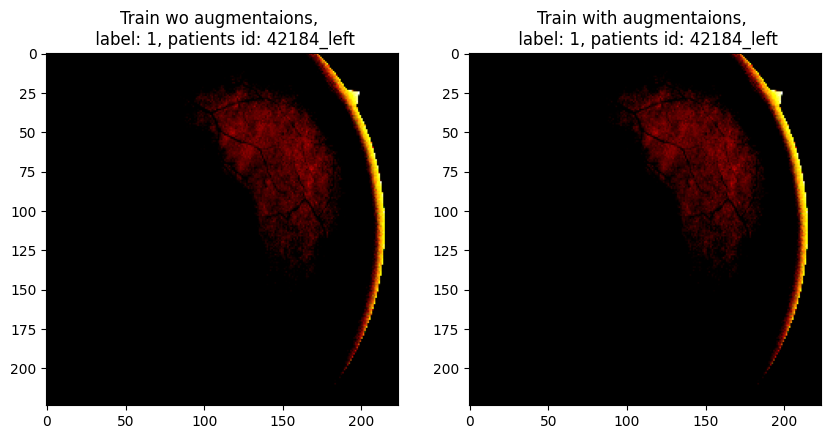

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


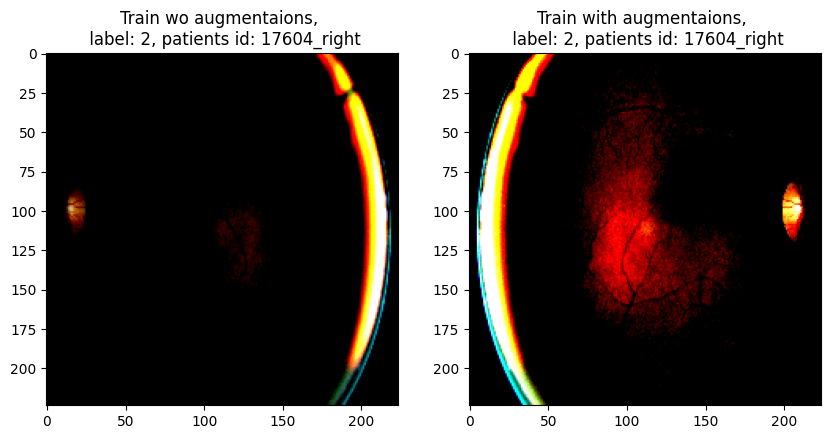

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


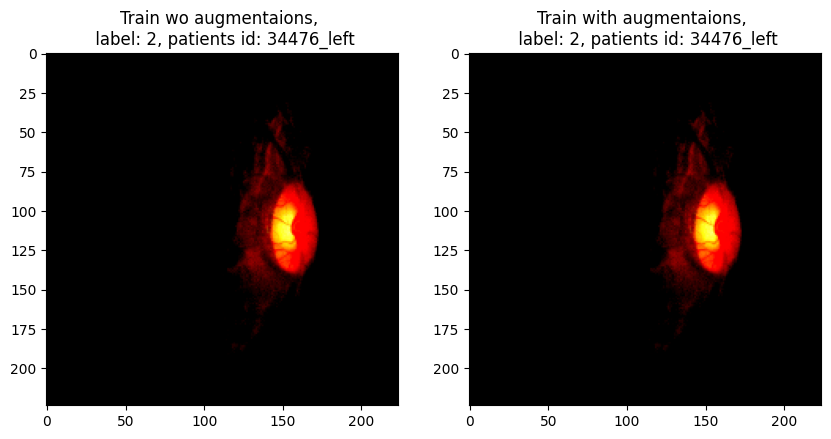

In [18]:
import matplotlib.pyplot as plt


dm_with_augm = RetinaDatamoduleTL(
            
                  batch_size= 1,
                   num_workers= 1, 
                   seed = 3,
         weighted_sampler=True,
        use_augmentations=True,
            )

dm_with_augm.setup(stage = Stage.fit, subset = SplitSubset.train)


dm_wo_augm = RetinaDatamoduleTL(
            
                  batch_size= 1,
                   num_workers= 1, 
                   seed = 3,
         weighted_sampler=True,
        use_augmentations=False,
            )

dm_wo_augm.setup(stage = Stage.fit, subset = SplitSubset.train)

for i in range(5):
    fig, axes = plt.subplots(ncols=2, nrows = 1, figsize = (10, 5))
    
    
    item_dict_train  = next(iter(dm_with_augm.train_dataloader()))  
    item_dict_train_wo_augm  = next(iter(dm_wo_augm.train_dataloader()))
   
    
    axes[0].imshow(item_dict_train_wo_augm["image"][0].permute(1, 2, 0).numpy())
    axes[0].set_title(f"Train wo augmentaions, \n label: {item_dict_train_wo_augm['label'][0]}, patients id: {item_dict_train_wo_augm['record_name'][0]}")
    
    axes[1].imshow(item_dict_train["image"][0].permute(1, 2, 0).numpy())
    axes[1].set_title(f"Train with augmentaions, \n label: {item_dict_train['label'][0]}, patients id: {item_dict_train['record_name'][0]}")
    

    
    
    plt.show()
    plt.close()


## Set up the model - ResNet18


Now when we have the dataloader inplace, let's set up a model.
We'll use standart ResNet18 pretrained on Image Net which is available through torchvision.models. However, we'll do a few triks: 


1. To train this network on our 5 classes, we'll replace the last layer of ResNet fully connected layers that is supposed to predict 1000 classes with a set of fully connected layers that gradually decay the output size to 5. To do so, we will set original "fc" block to identity function and put a block of our fully connected set of layers afterwards. 
2. We embedd the functionality of either returning a class probabily or the output of pre-last layer(for extraction of latent features)

### Setting up a new set of fully connected layers 
We will replace set of fully connected layers that was in original ResNet with another set of fully connected layers that go to 5 classesand with functionality of returning either class probability or output of pre-last layer

In [19]:

class fc_block(nn.Module):
    """A set of fully connected layers to replace fc in pretrained ResNet18 
    """

    def __init__(self, in_features=512, num_classes=5) -> None:
        super().__init__()
        self.fc_seq = nn.Sequential(
            nn.Linear(in_features, in_features // 2),
            nn.ReLU(),
            nn.Linear(in_features // 2, in_features // 4),
            nn.ReLU(),
            nn.Linear(in_features // 4, in_features // 8),
            nn.ReLU(),
        )
        self.out_layer = nn.Linear(in_features // 8, num_classes)

    def forward(self, x: torch.Tensor, return_class: bool = False) -> torch.Tensor:
        """

        Args:
            x (torch.Tensor): input Tensor
            return_class (bool, optional): If set to True, will return class probabilities. Otherwise will return output of pre-last layer. Defaults to False.

        Returns:
            torch.Tensor
        
        """
        x_lat = self.fc_seq(x)
        if return_class:
            out = self.out_layer(x_lat)
            return out
        else:
            return x_lat

In [20]:
# Let's see an example of it:

fc_block_example = fc_block()
input_tensor = torch.zeros((1, 512))
out_latents = fc_block_example(input_tensor, return_class = False)
out_classes = fc_block_example(input_tensor, return_class = True)

In [21]:
summary(fc_block_example, (1, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         131,328
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 64]           8,256
              ReLU-6                [-1, 1, 64]               0
Total params: 172,480
Trainable params: 172,480
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.66
Estimated Total Size (MB): 0.67
----------------------------------------------------------------


In [22]:
print(f"input shape: {input_tensor.shape}, \noutput shape when predicting latents: {out_latents.shape},\noutput shape when predicting class probabilities: {out_classes.shape}")

input shape: torch.Size([1, 512]), 
output shape when predicting latents: torch.Size([1, 64]),
output shape when predicting class probabilities: torch.Size([1, 5])


### ResNet Wrapper with our new functionality
Now let's set the identity class to replace original fc block and wrap everything under one class - ResNetAdapted

In [23]:
class Identity(nn.Module):
    """An identity class to replace arbitrary layers in pretrained models.
    Example::
        from pl_bolts.utils import Identity
        model = resnet18()
        model.fc = Identity()
    """

    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return x
    

class ResNetAdapted(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        model = tm.resnet18(pretrained=True)
        fc = fc_block(in_features=model.fc.in_features, num_classes=num_classes)

        self.model = model
        self.model.fc = Identity()
        self.new_fc = fc
        self.num_classes = num_classes

    def forward(self, x: torch.Tensor, return_class: bool = False) -> torch.Tensor:
        """

        Args:
            x (torch.Tensor): input Tensor
            return_class (bool, optional): If set to True, will return class probabilities. Otherwise will return output of pre-last layer. Defaults to False.

        Returns:
            torch.Tensor
        
        """
        x = self.model(x)
        out = self.new_fc(x, return_class=return_class)
        return out


In [16]:
# Let's see an example of it:

resnet18_adapted = ResNetAdapted()
input_tensor = torch.zeros((1, 3, 256, 256))
out_latents = resnet18_adapted(input_tensor, return_class = False)
out_classes = resnet18_adapted(input_tensor, return_class = True)

/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
summary(resnet18_adapted, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [18]:
print(f"input shape: {input_tensor.shape}, \noutput shape when predicting latents: {out_latents.shape},\noutput shape when predicting class probabilities: {out_classes.shape}")

input shape: torch.Size([1, 3, 256, 256]), 
output shape when predicting latents: torch.Size([1, 64]),
output shape when predicting class probabilities: torch.Size([1, 5])


## Model-related wrappers

### Preparing pytorch-lightning module

Following the example (https://lightning.ai/docs/pytorch/stable/starter/introduction.html)[example] in Pytorch-lightning basic tutorial, we'll create our ResNetExtractor class that will have all the basic functionality for training/prediction steps that work on teh batches

In [24]:
class ResNetExtractor(pl.LightningModule):
    """
    TorchLightning module
    """

    def __init__(
        self,
        model_name: str= "model",
        num_classes:int =5,
        lr_policy: str = "constant",
        lr: float = 0.0001,
        find_lr: bool = True,
        num_epochs: int = 2000,
        n_ep_decay: int = 600,
        seed:int = 5
    ):
        super(ResNetExtractor, self).__init__()
        self.save_hyperparameters()

        self.model_name = model_name
        self.model = ResNetAdapted(num_classes=self.hparams.num_classes)
        self.criterion = nn.CrossEntropyLoss()



    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=self.hparams.lr,
            betas=(0.5, 0.999),
            weight_decay=0.0001,
        )
        lr_scheduler = self.get_scheduler(
            optimizer,
            self.hparams.lr_policy,
            self.hparams.n_ep_decay,
            self.hparams.num_epochs,
            self.hparams.lr,
        )
        if lr_scheduler is not None:
            return [optimizer], [lr_scheduler]
        else:
            return [optimizer]
    
    def get_scheduler(self, optimizer, lr_policy, n_ep_decay, n_ep, init_lr):
        if lr_policy == "lambda":

            def lambda_rule(ep):
                lr_l = 1.0 - max(0, ep - n_ep_decay) / float(n_ep - n_ep_decay + 1)
                return lr_l

            scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
        elif lr_policy == "step":
            scheduler = lr_scheduler.StepLR(optimizer, step_size=n_ep_decay, gamma=0.1)

        elif lr_policy == "cyclic":
            scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer,
                T_0=n_ep_decay,  # Number of iterations for the first restart
                T_mult=1,  # A factor increases TiTi​ after a restart
                eta_min=init_lr,
            )  # Minimum learning rate

        elif lr_policy == "constant":
            scheduler = None

        else:
            return NotImplementedError("no such learn rate policy")
        return scheduler

    def forward(self, imgs, return_class=False):
        outputs = self.model(imgs, return_class=return_class)
        return outputs

    def predict_step(self, batch, batch_idx):
        if not hasattr(self, "prediction_type"):
            self.prediction_type = PredictionType.latents

        if self.prediction_type == PredictionType.latents:
            imgs, y = batch["image"], batch["label"]
            record_name = batch["record_name"]
            output = self.forward(imgs)
            return {"latents": output, "id": record_name, "gt": y}
        
        elif self.prediction_type == PredictionType.class_label:
            imgs, y = batch["image"], batch["label"]
            record_name = batch["record_name"]
            y_hat = self(imgs, return_class=True)
            preds = self.get_class_prediction(y_hat)
            return {"predicted_class": preds, "id": record_name, "gt": y}

    def test_step(self, batch, batch_idx):
        imgs, y = batch["image"], batch["label"]
        record_name = batch["record_name"]
        y_hat = self(imgs, return_class=True)
        preds = self.get_class_prediction(y_hat)
        return {"predicted_class": preds, "id": record_name, "gt": y}

    def get_loss(self, y_hat, y):
        return self.criterion(y_hat, y.to(torch.int64))

    def get_class_prediction(self, y_hat):
        preds = torch.argmax(F.softmax(y_hat.detach(), dim=1), dim=1)
        return preds

    def training_step(self, batch, batch_nb):
        imgs, y = batch["image"], batch["label"]
        y_hat = self(imgs, return_class=True)

        loss = self.get_loss(y_hat, y)
        preds = self.get_class_prediction(y_hat)
        self.log("train_loss", loss.item(), prog_bar=True)

        if y.shape[0] > 1:
            f1 = f1_score(
                preds=preds,
                target=y.to(torch.int),
                task="multiclass",
                num_classes=self.model.num_classes,
            )
            self.log("train_f1", f1.item(), prog_bar=True)

            acc = accuracy(
                preds,
                y.to(torch.int),
                task="multiclass",
                num_classes=self.model.num_classes,
            )
            self.log("train_acc", acc.item(), prog_bar=True)

        return loss

    def validation_step(self, batch, batch_nb):
        imgs, y = batch["image"], batch["label"]

        y_hat = self(imgs, return_class=True)

        loss = self.get_loss(y_hat, y)
        preds = self.get_class_prediction(y_hat)

        self.log("val_loss", loss.item(), prog_bar=True)

        if y.shape[0] > 1:
            f1 = f1_score(
                preds=preds,
                target=y.to(torch.int),
                task="multiclass",
                num_classes=self.model.num_classes,
            )
            self.log("val_f1", f1.item(), prog_bar=True)

            acc = accuracy(
                preds,
                y.to(torch.int),
                task="multiclass",
                num_classes=self.model.num_classes,
            )
            self.log("val_acc", acc.item(), prog_bar=True)

        return loss

    def set_prediction_type(self, prediction_type: PredictionType):
        self.prediction_type = prediction_type

### Now, lets prepare class for parameters that will be saved for respoducibulity

In [28]:
class ModelOptions:
    evaluation_list = [
        "batch_size",
        "subset",
        "model_name",
        "task",
        "nThreads",
        "result_dir",
        "model_path",
        "model_dir",
        "train",
        "limit_predict_batches",
    ]
    computational_list = [
        "gpu",
        "gpu_device",
        "model_name",
    ]
    resume_list = ["model_name",
                   "model_path", 
                   ]
    
    def __init__(
        self,
        train: bool = True,
        resume: bool = False, 
        batch_size: int = 64,
        num_classes: int = 5,
        overwrite: bool = False,
        num_workers: int = 2,
        lr_policy: str = "constant",
        lr: float = 0.0001,
        find_lr: bool = True,
        num_epochs: int = 2000,
        n_ep_decay: int = 600,
        gpu: bool = False,
        model_name: str = "resnet18ImgNetFC",
        weighted_sampler: bool = True,
        seed: int = 5,
        deterministic: bool = True,
        augmentations: bool = True,
        compensation: str = "memory",
        limit_train_batches: Union[int, float, None] = None,
        limit_val_batches: Union[int, float, None] = None,
        limit_predict_batches: Union[int, float, None] = None,
        gradient_clip_val: Union[int, float, None] = None,
        **kwargs,
    ):
        self.__dict__.update(**{key: item for key, item in locals().items()})

    def prepare_commandline(self):
        if not self.train or (self.train and self.resume):
            if not hasattr(self, "model_path"):
                self.model_path = MODELS_DIR / f"{self.model_name}"

            with open(os.path.join(self.model_path, "params.pkl"), "rb") as f:
                opts_dict = pkl.load(f)

            for key, item in opts_dict.items():
                if key in self.computational_list:
                    continue
                    
                elif hasattr(self, "resume") and self.resume and key in self.resume_list and self.__dict__[key] is not None:
                    continue

                elif not self.train and key in self.evaluation_list:
                    continue
                else:
                    setattr(self, key, item)

        elif self.train and not self.resume:
            model_name = self.get_model_name(self.model_name)
            self.model_path, self.model_name = self._create_model_folder(model_name)
            self.save_opts()
            print(self.model_path, self.model_name)

        else:
            pass

    def _create_model_folder(self, name):
        model_dir = MODELS_DIR / name
        if os.path.exists(model_dir):
            if (not self.overwrite) and len(os.listdir(model_dir)) > 0:
                print(
                    f"Since overwrite={self.overwrite} and path already exists, creating new unique name"
                )
                name = self.change_model_name(name)
                model_dir = os.path.join(MODELS_DIR, name)

            else:
                print(
                    f"Since overwrite={self.overwrite} and path already exists, cleaning it"
                )
                shutil.rmtree(model_dir)

        os.makedirs(model_dir, exist_ok=True)
        return model_dir, name

    def get_model_name(self, model_name):
        return f"{model_name}-version0"

    def change_model_name(self, model_name):
        name = model_name.split("-version")[0]
        version = np.max(
            [
                int(mn.split("-version")[-1])
                for mn in glob.glob(str(MODELS_DIR / f"{name}*"))
            ]
        )
        return f"{name}-version{version+1}"

    def save_opts(self):
        with open(os.path.join(self.model_path, "params.pkl"), "wb") as f:
            pkl.dump(self.__dict__, f)

    def get_dict(self):
        return self.__dict__

### Finally, we'll make a wrapper with high-level functionality for training/latents extraction

The functions we'll use from this class are train(..), get_latents(..) and get_class_labels(..)

In [29]:
def seed_torch(seed=5):
    random.seed(seed)
    pl.seed_everything(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    

class NNHelper:
    def __init__(self, model_opts):
        self.model_name = model_opts.model_name
        self.model_path = Path(model_opts.model_path)
        self.model_opts = model_opts

    def train(self, resume:bool = False):
        """
        Generic training function. Will train the model with self.model_opts parameters 
        and save 2 types of weights - the one from last available checkpoint (under MODELS_DIR / self.model_name / "last")
        and anotehr from the epoch with best validation loss (under MODELS_DIR / self.model_name / "best")
        """

        seed_torch(self.model_opts.seed)
        self.init_model()
        self.train_dm = self.get_dm(stage=Stage.fit)

        # Ensure that all operations are deterministic on GPU (if used) for reproducibility
        torch.backends.cudnn.determinstic = self.model_opts.deterministic

        best_loss_checkpoint_callback = ModelCheckpoint(
            monitor="val_loss",
            dirpath=self.model_path / "best_loss",
            filename="bestValLoss-{epoch}-{step}-{val_loss:.02f}",
            save_top_k=1,
            save_on_train_epoch_end=True,
        )

        last_checkpoint_callback = ModelCheckpoint(
            dirpath=self.model_path / "last",
            save_on_train_epoch_end=True,
            save_last=True,
            filename="checkpoint-{epoch}-{step}",
        )

        tb_logger = pl_loggers.TensorBoardLogger(
            save_dir=self.model_path, name="tensorboard", version="fixed_version"
        )
        lr_logger = LearningRateMonitor(logging_interval="step", log_momentum=False)

        trainer = pl.Trainer(
            accelerator=self.accelerator,
            max_epochs=self.model_opts.num_epochs,
            default_root_dir=self.model_path,
            callbacks=[
                best_loss_checkpoint_callback,
                last_checkpoint_callback,
                lr_logger,
            ],
            logger=[tb_logger],
            enable_progress_bar=True,
            log_every_n_steps=1,
            limit_train_batches=self.model_opts.limit_train_batches,
            limit_val_batches=self.model_opts.limit_val_batches,
            gradient_clip_val=self.model_opts.gradient_clip_val,
        )
        if not resume:
            if self.model_opts.find_lr:
                tuner = pl.tuner.Tuner(trainer)

                # Tune learning rate
                lr_finder = tuner.lr_find(
                    self.extractor,
                    train_dataloaders=self.train_dm.train_dataloader(),
                    val_dataloaders=self.train_dm.val_dataloader(),
                )

                new_lr = lr_finder.suggestion()
                if new_lr is None:
                    print(
                        "new_lr was not found. Using default lr: "
                        + str(self.extractor.hparams.lr)
                    )
                else:
                    print("new_lr: " + str(new_lr))
                    self.extractor.hparams.lr = new_lr

            trainer.fit(self.extractor, datamodule=self.train_dm)
        else: 
            self.ckpt_path = self.find_best_ckpt(self.model_path, which_checkpoint="last")

            trainer.fit(self.extractor, datamodule=self.train_dm, ckpt_path=self.ckpt_path)
    
    def get_latents(self, subset=SplitSubset.test, which_checkpoint="best"):
        """This funcion is meant for predicting latent features from the pre-last layer of our trained model.

        Args:
            subset: Subset which we want to use for prediction: train/val/test. Defaults to SplitSubset.test.
            which_checkpoint (str, optional): From which checkpoint to predict. If st to "best", will use the models checkpoint with the lowest validation loss during the training. If set to "last", will use the weights from the latest checkpoint. Defaults to "best".
            The result will be saved as a dataframe under  RESULTS_DIR / self.model_name / "latents" / {which_checkpoint} / latents-{subset}.csv
        """
        self.init_model() # Here, we only init model's layers - the weights are loaded in the self.predict_class(..) function

        dataloader = self.get_dm(stage=Stage.test, subset=subset).test_dataloader()

        latents, info_dict = self.predict_latents(
            dataloader, which_checkpoint=which_checkpoint
        )

        feat_cols = [f"feature-{feat_idx}" for feat_idx in range(latents.shape[1])]
        latent_df = pd.DataFrame(latents, columns=feat_cols)
        info_df = pd.DataFrame.from_records(info_dict)

        res_by_record_df = pd.merge(
            info_df, latent_df, left_index=True, right_index=True
        )
        res_by_record_df["gt_class_decoded"] = res_by_record_df.apply(
            lambda x: label_map[int(x["gt_class"])], axis=1
        )
        self.save_latents_predictions(
            res_pd=res_by_record_df,
            subset=subset.value,
            which_checkpoint=which_checkpoint,
        )

    def get_class_labels(self, subset=SplitSubset.test, which_checkpoint="best"):
        """This funcion is meant for predicting class labels from our trained model.

        Args:
            subset: Subset which we want to use for prediction: train/val/test. Defaults to SplitSubset.test.
            which_checkpoint (str, optional): From which checkpoint to predict. If st to "best", will use the models checkpoint with the lowest validation loss during the training. If set to "last", will use the weights from the latest checkpoint. Defaults to "best".
            The result will be saved as a dataframe under  RESULTS_DIR / self.model_name / "class_predictions" / {which_checkpoint} / {subset}_preds.csv
        """
        
        self.init_model() # Here, we only init model's layers - the weights are loaded in the self.predict_class(..) function
        dataloader = self.get_dm(stage=Stage.test, subset=subset).test_dataloader()
        res_dict = self.predict_class(dataloader, which_checkpoint=which_checkpoint)
        res_by_record_df = pd.DataFrame.from_records(res_dict)

        res_by_record_df["gt_class_decoded"] = res_by_record_df.apply(
            lambda x: label_map[int(x["gt_class"])], axis=1
        )
        res_by_record_df["predicted_class_decoded"] = res_by_record_df.apply(
            lambda x: label_map[int(x["predicted_class"])], axis=1
        )

        self.save_class_predictions(
            res_pd=res_by_record_df,
            subset=subset.value,
            which_checkpoint=which_checkpoint,
        )

    def init_model(self, stage=Stage.fit):
        if torch.cuda.is_available():
            self.accelerator = "gpu"
        else:
            self.accelerator = "cpu"

        self.extractor = ResNetExtractor(
            model_name=self.model_name,
            num_classes=self.model_opts.num_classes,
            lr_policy=self.model_opts.lr_policy,
            lr = self.model_opts.lr,
            find_lr = self.model_opts.find_lr,
            num_epochs = self.model_opts.num_epochs,
            n_ep_decay = self.model_opts.n_ep_decay,
            seed = self.model_opts.seed, 
        )

    def get_dm(self, subset: SplitSubset = SplitSubset.train, stage: Stage = Stage.fit):
        dm = RetinaDatamoduleTL(
            batch_size=self.model_opts.batch_size,
            num_workers=self.model_opts.num_workers,
            seed=self.model_opts.seed,
            weighted_sampler=self.model_opts.weighted_sampler,
            use_augmentations=self.model_opts.augmentations,
        )

        dm.setup(stage=stage, subset=subset)
        return dm
    
    def predict_latents(self, dataloader, which_checkpoint="best"):

        # meant for predicting latents
        self.extractor.set_prediction_type(PredictionType.latents)

        trainer = pl.Trainer(
            inference_mode=True,
            limit_predict_batches=self.model_opts.limit_predict_batches,
        )
        ckpt_path = self.find_best_ckpt(
            os.path.join(self.model_path), which_checkpoint=which_checkpoint
        )

        lat = trainer.predict(
            model=self.extractor, dataloaders=dataloader, ckpt_path=ckpt_path
        )

        latents = torch.cat([el["latents"] for el in lat]).cpu().detach().numpy()

        gt = np.concatenate([el["gt"] for el in lat])
        pat_id = np.concatenate([el["id"] for el in lat])

        return latents, {"id": pat_id, "gt_class": gt}

    def predict_class(self, dataloader, which_checkpoint="best"):
        # meant for predicting class labels

        self.extractor.set_prediction_type(PredictionType.class_label)

        trainer = pl.Trainer(
            inference_mode=True,
            limit_predict_batches=self.model_opts.limit_predict_batches,
            limit_test_batches=self.model_opts.limit_predict_batches,
        )

        ckpt_path = self.find_best_ckpt(
            os.path.join(self.model_path), which_checkpoint=which_checkpoint
        )

        cl = trainer.predict(
            model=self.extractor, dataloaders=dataloader, ckpt_path=ckpt_path
        )

        class_labels = (
            torch.cat([el["predicted_class"] for el in cl]).cpu().detach().numpy()
        )

        gt = np.concatenate([el["gt"] for el in cl])
        pat_id = np.concatenate([el["id"] for el in cl])

        return {"predicted_class": class_labels, "id": pat_id, "gt_class": gt}


    def save_latents_predictions(self, res_pd, subset, which_checkpoint=None):
        filepath = RESULTS_DIR / self.model_name / "latents"
        if which_checkpoint is not None:
            filepath = filepath / which_checkpoint

        os.makedirs(filepath, exist_ok=True)
        print(f"Saving under path: {filepath}")
        res_pd.to_csv(filepath / f"latents-{subset}.csv", index=False)

    def save_class_predictions(self, res_pd, subset, which_checkpoint=None):
        filepath = RESULTS_DIR / self.model_name / "class_predictions"
        if which_checkpoint is not None:
            filepath = filepath / which_checkpoint

        os.makedirs(filepath, exist_ok=True)
        print(f"Saving under path: {filepath}")
        res_pd.to_csv(filepath / f"{subset}_preds.csv", index=False)

    def find_best_ckpt(
        self, checkpoint_path, which_checkpoint, selection_metric="loss", ext=".ckpt"
    ):
        """
        Find the highest epoch in the Test Tube file structure.
        :param ckpt_folder: dir where the checpoints are being saved.
        :return: Integer of the highest epoch reached by the checkpoints.
        """

        if which_checkpoint == "best":
            checkpoint_path = os.path.join(checkpoint_path, f"best_{selection_metric}")
            avail_models = [
                str(Path(x).stem)
                for x in os.listdir(checkpoint_path)
                if ("epoch" in x and x.endswith(ext))
            ]

            avail_models_info = sorted(
                [
                    {
                        "fullname": x,
                        "epoch": int((x.split("-")[1].split("=")[-1])),
                        "step": int((x.split("-")[2].split("=")[-1])),
                        "loss": float((x.split("-")[3].split("=")[-1])),
                    }
                    for x in avail_models
                ],
                key=lambda d: (-d["loss"], d["epoch"]),
                reverse=True,
            )

        elif which_checkpoint == "last":
            checkpoint_path = os.path.join(checkpoint_path, "last")
            avail_models = [
                str(Path(x).stem)
                for x in os.listdir(checkpoint_path)
                if ("epoch" in x and x.endswith(ext))
            ]

            avail_models_info = sorted(
                [
                    {
                        "fullname": x,
                        "epoch": int((x.split("-")[1].split("=")[-1])),
                        "step": int((x.split("-")[2].split("=")[-1])),
                    }
                    for x in avail_models
                ],
                key=lambda d: (d["epoch"], d["step"]),
                reverse=True,
            )

        last_avail_model = avail_models_info[0]["fullname"]
        last_avail_model = os.path.join(checkpoint_path, f"{last_avail_model}{ext}")
        return last_avail_model



## Now, lets actually train the model

In [34]:
model_name = "resnet18ImgNetFC_test"
model_opts = ModelOptions(
    model_name=model_name,
    overwrite=True,
    lr=0.0004,
    # Uncomment below for short testing- the training will only run on 1 batch of train and validation subsets for 2 epochs
#     num_epochs = 2, 
#     limit_train_batches =1, 
#     limit_val_batches =2
)
model_opts.prepare_commandline()

/dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/experiments/resnet18ImgNetFC_test-version0 resnet18ImgNetFC_test-version0


In [35]:
model_opts.__dict__

{'self': <__main__.ModelOptions at 0x2b338bb003d0>,
 'train': True,
 'batch_size': 64,
 'num_classes': 5,
 'overwrite': True,
 'num_workers': 2,
 'lr_policy': 'constant',
 'lr': 0.0004,
 'find_lr': True,
 'num_epochs': 2000,
 'n_ep_decay': 600,
 'gpu': False,
 'model_name': 'resnet18ImgNetFC_test-version0',
 'weighted_sampler': True,
 'seed': 5,
 'deterministic': True,
 'augmentations': True,
 'compensation': 'memory',
 'limit_train_batches': None,
 'limit_val_batches': None,
 'limit_predict_batches': None,
 'gradient_clip_val': None,
 'kwargs': {},
 'model_path': PosixPath('/dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/experiments/resnet18ImgNetFC_test-version0')}

In [23]:
helper = NNHelper(model_opts)

In [24]:
helper.train()

[rank: 0] Global seed set to 5


Setting up for stage: Stage.fit
loaded labels from /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/processed_data/data_split/train_df.csv, shape: (18386, 6)
loaded labels from /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/processed_data/data_split/val_df.csv, shape: (3066, 6)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNetAdapted    | 11.3 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.397    Total estimated model params size (MB)


Setting up for stage: fit
loaded labels from /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/processed_data/data_split/train_df.csv, shape: (18386, 6)
loaded labels from /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/processed_data/data_split/val_df.csv, shape: (3066, 6)


SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-p

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [30]:
#resume training

In [31]:
model_name = "resnet18ImgNetFC_test-version0"
model_opts = ModelOptions(
    model_name=model_name,
       resume  = True, 
    # lr=0.0004,
    # Uncomment below for short testing- the training will only run on 1 batch of train and validation subsets for 2 epochs
#     num_epochs = 2, 
#     limit_train_batches =1, 
#     limit_val_batches =2
)
model_opts.prepare_commandline()

In [32]:
model_opts.__dict__

{'self': <__main__.ModelOptions at 0x2b74715ce250>,
 'train': True,
 'resume': True,
 'batch_size': 64,
 'num_classes': 5,
 'overwrite': True,
 'num_workers': 2,
 'lr_policy': 'constant',
 'lr': 0.0004,
 'find_lr': True,
 'num_epochs': 2000,
 'n_ep_decay': 600,
 'gpu': False,
 'model_name': 'resnet18ImgNetFC_test-version0',
 'weighted_sampler': True,
 'seed': 5,
 'deterministic': True,
 'augmentations': True,
 'compensation': 'memory',
 'limit_train_batches': None,
 'limit_val_batches': None,
 'limit_predict_batches': None,
 'gradient_clip_val': None,
 'kwargs': {},
 'model_path': PosixPath('/dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/experiments/resnet18ImgNetFC_test-version0')}

In [33]:
helper = NNHelper(model_opts)

In [34]:
helper.train(resume = True)

[rank: 0] Global seed set to 5
/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up for stage: Stage.fit
loaded labels from /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/processed_data/data_split/train_df.csv, shape: (18386, 6)
loaded labels from /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/processed_data/data_split/val_df.csv, shape: (3066, 6)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zov/ehrapy_nastassya.horlava/project_folder_tutorial/experiments/resnet18ImgNetFC_test-version0/best_loss exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zov/ehrapy_nastassya.horlava/project_folder_tutorial/experiments/resnet18ImgNetFC_test-version0/last exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Restoring st

Setting up for stage: fit
loaded labels from /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/processed_data/data_split/train_df.csv, shape: (18386, 6)
loaded labels from /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/processed_data/data_split/val_df.csv, shape: (3066, 6)



  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNetAdapted    | 11.3 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.397    Total estimated model params size (MB)
Restored all states from the checkpoint at /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/experiments/resnet18ImgNetFC_test-version0/last/checkpoint-epoch=79-step=23040.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_

Training: 0it [00:00, ?it/s]

/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [1]:
%load_ext tensorboard

## Now, let's predict latents and classes 

In [36]:
model_name = "resnet18ImgNetFC_test-version0"
inference_opts = ModelOptions(
    train=False, model_name=model_name, 
    # Uncomment below for shortlt testing if teh inference works - will only run on 1 batch of predict subset
    # limit_predict_batches=2
)
inference_opts.prepare_commandline()

In [31]:
helper = NNHelper(inference_opts)
helper.get_class_labels(subset=SplitSubset.test, which_checkpoint="best")

/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Plea

Settin up for stage: Stage.test, subset: SplitSubset.test
loaded labels from /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/processed_data/data_split/test_df.csv, shape: (9194, 6)


Loaded model weights from the checkpoint at /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/experiments/resnet18ImgNetFCtest-version0/best_loss/bestValLoss-epoch=1-step=4-val_loss=1.58.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.
/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Saving under path: /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/results/resnet18ImgNetFCtest-version0/class_predictions/best


In [32]:
helper.get_latents(subset=SplitSubset.test, which_checkpoint="best")

/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Plea

Settin up for stage: Stage.test, subset: SplitSubset.test
loaded labels from /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/processed_data/data_split/test_df.csv, shape: (9194, 6)


Loaded model weights from the checkpoint at /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/experiments/resnet18ImgNetFCtest-version0/best_loss/bestValLoss-epoch=1-step=4-val_loss=1.58.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.
/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Saving under path: /dss/dsshome1/02/di93zov/Projects/ehrapy_DR_latents/ehrapy_latents/notebooks/tutorial/project_folder/results/resnet18ImgNetFCtest-version0/latents/best


## Lastly, showing the predictions in umap/velocity plot

In [1]:
import scanpy as sc
import pandas as pd
import scvelo as scv
import cellrank as cr
import ehrapy as ep
import numpy as np
import matplotlib.pyplot as plt
import ehrapy as ep
import tempfile

from cellrank.tl.kernels import ConnectivityKernel
from cellrank.tl.kernels import PseudotimeKernel

Installed version 0.3.0 of ehrapy is outdated. Newest version is 0.5.0!

In [2]:
import matplotlib.colors as mcolors
palette = {
    "Normal": mcolors.to_rgba("#1CFF4B"),
    "Mild": mcolors.to_rgba("#04C6DB"),
    "Medium": mcolors.to_rgba("#1222F0"),
    "Severe": mcolors.to_rgba("#AF00DB"),
    "Proliferative": mcolors.to_rgba("#FF1202"),
}

In [3]:
def get_undersampled_adata(df, seed = 5):
    val_counts = pd.DataFrame(df.gt_class_decoded.value_counts())
    min_size = val_counts["count"].min()
    undersampled = []
    for name, group in df.groupby("gt_class_decoded"):
        if group.shape[0] > min_size:
            undersampled.append(group.sample(min_size, random_state = seed))
        else:
            undersampled.append(group)
    undersampled_df = pd.concat(undersampled, ignore_index=True)
    return undersampled_df

In [7]:
model_name = "resnet18ImgNetFC_test-version0"
chptn = "last"
filepath = RESULTS_DIR / model_name / "latents" / chptn / "latents-test.csv"
if filepath.exists():
    columns_obs_only_ = ["gt_class", "gt_class_decoded"]

    df = pd.read_csv(str(filepath))
    # df = df[df.gt_class_decoded!= "Proliferative"]
    df_undersampled = get_undersampled_adata(df, seed = 6)
    adata = ep.ad.df_to_anndata(
        df_undersampled,
        index_column="id",
        columns_obs_only=["gt_class", "gt_class_decoded"],
    )


display(adata)
print(adata.obs.gt_class_decoded.value_counts())

2023-10-02 11:32:47,566 - root INFO - Transformed passed dataframe into an AnnData object with n_obs x n_vars = `790` x `64`.


AnnData object with n_obs × n_vars = 790 × 64
    obs: 'gt_class', 'gt_class_decoded'
    uns: 'numerical_columns', 'non_numerical_columns'
    layers: 'original'

gt_class_decoded
Medium           158
Mild             158
Normal           158
Proliferative    158
Severe           158
Name: count, dtype: int64


/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/dss/dsshome1/02/di93zov/anaconda3/envs/ehrapy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


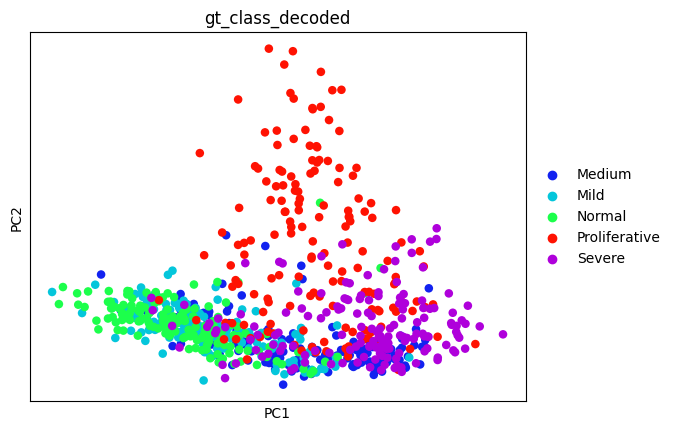

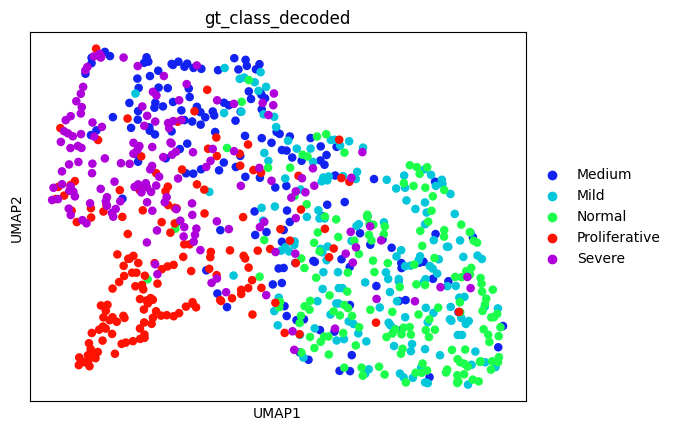

In [8]:
# seed_torch(seed=5) 
filepath =  Path("project_folder/plots") / model_name
os.makedirs(filepath, exist_ok = True)

ep.pp.pca(adata)
ep.pp.neighbors(adata)

# UMAP
ep.tl.umap(adata)
ep.pl.pca(adata, color=["gt_class_decoded"], palette=palette, show =False)

plt.savefig(filepath / "pca.png", bbox_inches="tight")
    
ep.pl.umap(adata, color=["gt_class_decoded"], palette=palette, show =False)
plt.savefig(filepath / "umap.png", bbox_inches="tight")


  0%|          | 0/790 [00:00<?, ?cell/s]

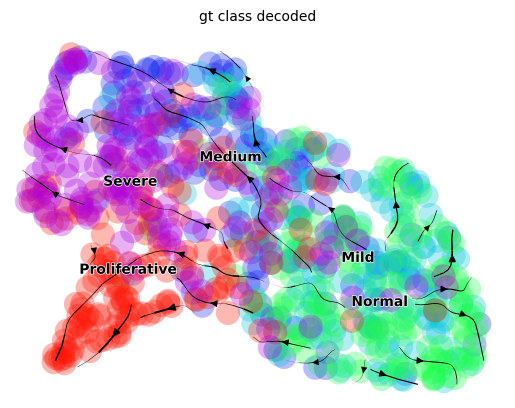

In [28]:
adata.uns["iroot"] = np.flatnonzero(adata.obs["gt_class_decoded"] == "Normal")[10]
ep.tl.dpt(adata)
pk = PseudotimeKernel(adata)
pk.compute_transition_matrix(threshold_scheme="soft")

pk.compute_projection(basis="umap")
# fig, axes= plt.subplots(1, 1, figsize = (6, 5))

ax = scv.pl.velocity_embedding_stream(
    adata,
    vkey="T_fwd",
    basis="umap",
    # ax = axes [1],
    # title = title,
    color="gt_class_decoded",
    density=0.5,
    xlim = [-1.5, 14], 
    ylim = [1, 14], 
    
    show = False
    # ax = axes
)
# plt.show()
plt.savefig(filepath / "velocity_stream.png", bbox_inches="tight")


### Predictions

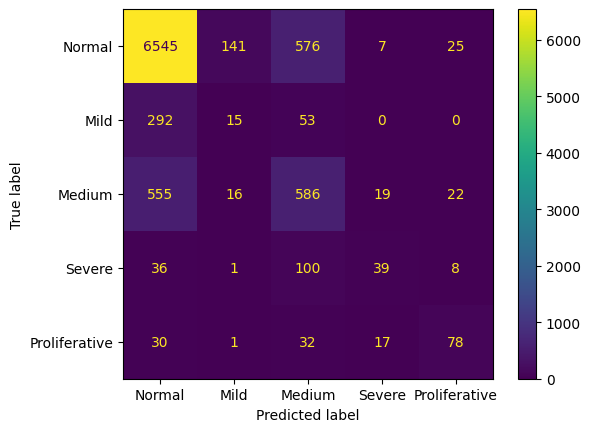

In [12]:
from sklearn.metrics import (
    classification_report,
    mean_squared_error,
    mean_absolute_error,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# ckptn = "last"
res_path = RESULTS_DIR / model_name / "class_predictions" /chptn/ f"test_preds.csv"

preds = pd.read_csv(res_path)
labels = [
    el for el in label_map.values() if el in list(preds.gt_class_decoded.unique())
]
cm = confusion_matrix(
    preds.gt_class_decoded.values.ravel(),
    preds.predicted_class_decoded.values.ravel(),
    labels=labels,
)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot()